# Ecuación normal

Normal equation took 0.2184530003432883 ms
Average error for normal equation: 481.47939131351865


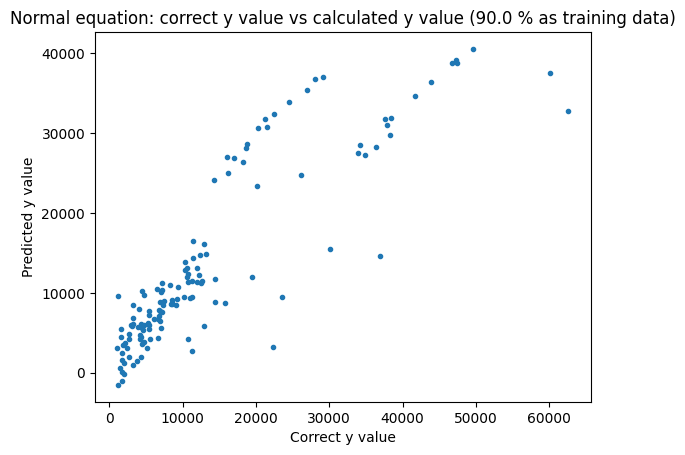

In [6]:
from enum import Enum
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tabulate import tabulate

PROYECT_HOME = os.path.join("")


class Methods(Enum):
    """
    Enum for easier identification of conditionals in the code, regarding
    methods used.
    """

    NORMAL_EQUATION = "ne"
    BATCH_GRADIENT_DESCENT = "bgd"


def add_ones_col(x: np.ndarray) -> np.ndarray:
    """
    Appends a 1 column as the first column of an array.

    Parameters:
    - x (np.ndarray): Array to which to append the 1 column.

    Returns:
    - np.ndarray: Original array, but with the 1 column appended at the start.
    """

    return np.append(np.ones((x.shape[0], 1)), x, axis=1)


def normal_equation(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calcualtes an array of weights, using the normal equation for the
    multivariable input x and the outputs y.

    Parameters:
    - x (np.ndarray): Multivariable input array.
    - y (np.ndarray): Output array.

    Returns:
    - np.ndarray: Array of weights calculated using the normal equation.
    """

    x_c = add_ones_col(x)
    return np.linalg.inv(x_c.T @ x_c) @ x_c.T @ y


def prepare_data(insurance_df: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces all non numeric values to numeric values in the dataframe, using
    custom mappings.

    Parameters:
    - insurace_df (pd.DataFrame): Dataframe with non numeric data.

    Returns:
    - pd.DataFrame: Original dataframe, with only numeric values.
    """

    # sex: male = 1, female = 0
    insurance_df["sex"] = np.where(insurance_df["sex"] == "male", 1, 0)

    # smoker: yes = 1, no = 0
    insurance_df["smoker"] = np.where(insurance_df["smoker"] == "yes", 1, 0)

    # field region: northeast: 0, northwest: 1, southeast: 2,  southwest: 3
    region_map = {"northeast": 0, "northwest": 1, "southeast": 2, "southwest": 3}
    insurance_df["region"] = insurance_df["region"].map(region_map)

    return insurance_df


def get_train_test_data(
    insurace_df: pd.DataFrame, training_data_percentage: float
) -> tuple[np.ndarray, np.ndarray]:
    """
    Separates the dataframe rows into two; one for training and one for
    testing.

    Parameters:
    - insurance_df (pd.DataFrame): Dataframe to be divided into training and test data.
    - training_data_percentage (float): Determines the percentage of the
      dataframe to be used for training. Has to be a value between 0 and 1.

    Returns:
    - np.ndarray: Training data.
    - np.ndarray: Testing data.
    """

    no_points = insurace_df.shape[0]

    no_training_points = int(training_data_percentage * no_points)

    insurace_df_numpy = insurace_df.to_numpy()

    training_points = insurace_df_numpy[0:no_training_points]
    testing_points = insurace_df_numpy[no_training_points:]

    return training_points, testing_points


def separate_data(data: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Separates the data into the multivariable input array and the output array.

    Parameters:
    - data (np.ndarray): Data array to be separated.

    Returns:
    - np.ndarray: Multivariable input array.
    - np.ndarray: Output array.
    """

    return data[:, :-1], data[:, data.shape[1] - 1].reshape(-1, 1)


def log_results(
    predicted_data_y: np.ndarray, testing_data_y: np.ndarray, method: Methods
) -> None:
    """
    Logs the expected, calculated and error percentage to a file.

    Parameters:
    - predicted_data_y (np.ndarray): Predicted output values.
    - testing_data_y (np.ndarray): Expected output values.
    - method (Methods): Defines which method was used, to define where to write
      the ouput.
    """

    cols = ["Expected", "Calculated", "Error percentage"]
    data: list[list] = []

    for i in range(predicted_data_y.shape[0]):
        expected_value = testing_data_y[i, 0]
        calculated_value = predicted_data_y[i, 0]
        error_percentage = expected_value / calculated_value * 100

        data.append([expected_value, calculated_value, error_percentage])

    if method == Methods.NORMAL_EQUATION:
        with open(
            os.path.join(PROYECT_HOME, "results", "insurance_normal_equation"), "w"
        ) as file:
            file.write(tabulate(data, headers=cols, tablefmt="grid"))
    elif method == Methods.BATCH_GRADIENT_DESCENT:
        with open(
            os.path.join(PROYECT_HOME, "results", "insurance_batch_gradient_descent"),
            "w",
        ) as file:
            file.write(tabulate(data, headers=cols, tablefmt="grid"))


def plot_results(
    predicted_data_y: np.ndarray,
    testing_data_y: np.ndarray,
    training_data_percentage: float,
    method: Methods,
) -> None:
    """
    Plots the resulting graph obtained by comparing the calculated values to
    the expected values.

    Parameters:
    - predicted_data_y (np.ndarray): Calculated data.
    - testing_data_y (np.ndarray): Expected data.
    - training_data_percentage (float): Percentage used for training.
    - method (Methods): Defines which method was used, for writing the plot
      title.
    """

    plt.plot(testing_data_y, predicted_data_y, ".")

    if method == Methods.NORMAL_EQUATION:
        plt.title(
            f"Normal equation: correct y value vs calculated y value ({training_data_percentage*100} % as training data)"
        )
    elif method == Methods.BATCH_GRADIENT_DESCENT:
        plt.title(
            f"Batch gradient descent: correct y value vs calculated y value ({training_data_percentage*100} % as training data)"
        )

    plt.xlabel("Correct y value")
    plt.ylabel("Predicted y value")
    plt.show()


def main():
    csv_file = os.path.join(PROYECT_HOME, "data", "insurance.csv")
    insurance_df = pd.read_csv(csv_file)

    insurance_df = prepare_data(insurance_df)

    training_data_percentage = 0.9
    training_data, testing_data = get_train_test_data(
        insurance_df, training_data_percentage
    )

    training_data_x, training_data_y = separate_data(training_data)
    testing_data_x, testing_data_y = separate_data(testing_data)

    start_time = time.perf_counter()
    theta = normal_equation(training_data_x, training_data_y)
    end_time = time.perf_counter()

    testing_data_x_c = add_ones_col(testing_data_x)
    predicted_data_y = testing_data_x_c @ theta

    average_error = np.sum(np.abs(predicted_data_y - testing_data_y)) / training_data_y.shape[0]  # type: ignore
    print(f"Normal equation took {(end_time - start_time) * 1000} ms")
    print(f"Average error for normal equation: {average_error}")

    log_results(predicted_data_y, testing_data_y, Methods.NORMAL_EQUATION)
    plot_results(
        predicted_data_y,
        testing_data_y,
        training_data_percentage,
        Methods.NORMAL_EQUATION,
    )


if __name__ == "__main__":
    main()

# Gradiente descendiente

Batch gradient descent took 95.64103399861779 ms
Average error for batch gradient descent: 603.2839983646084. (Learning rate: 0.0007. Iterations: 10000)


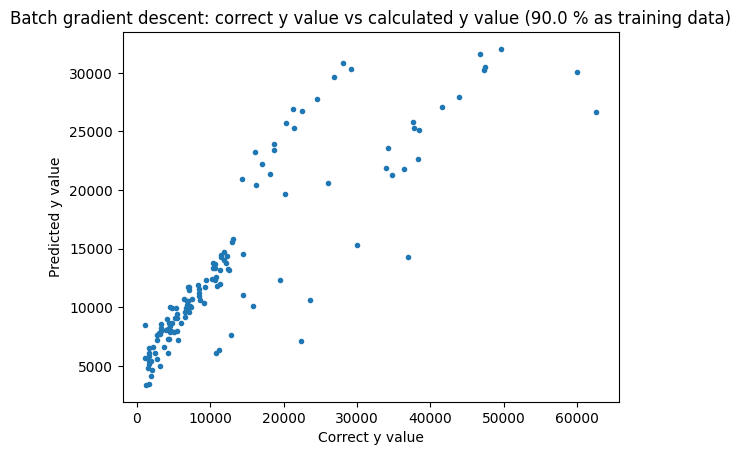

In [7]:
def batch_gradient_descent(
    training_data_x: np.ndarray,
    training_data_y: np.ndarray,
    iterations: int,
    learning_rate: float,
) -> np.ndarray:
    """
    Calculates an array of weights using the batch gradient descent algorithm
    with a specified learning rate and number of iterations.

    Parameters:
    - training_data_x (np.ndarray): Training multivariable input array.
    - training_data_y (np.ndarray): Training ouput array.
    - iterations (int): Number of iterations to be used.
    - learning_rate (float): Learning rate to be used.

    Returns:
    - np.ndarray: Array of weights.
    """

    training_data_x_c = add_ones_col(training_data_x)
    theta = np.random.randn(training_data_x_c.shape[1], 1)
    n = training_data_x_c.shape[0]

    for _ in range(iterations):
        multi = training_data_x_c @ theta - training_data_y
        gradients = (((1 / n) * learning_rate) * training_data_x_c.T) @ multi
        theta -= gradients

    return theta


def main():
    csv_file = os.path.join(PROYECT_HOME, "data", "insurance.csv")
    insurance_df = pd.read_csv(csv_file)

    insurance_df = prepare_data(insurance_df)

    training_data_percentage = 0.9
    training_data, testing_data = get_train_test_data(
        insurance_df, training_data_percentage
    )

    training_data_x, training_data_y = separate_data(training_data)
    testing_data_x, testing_data_y = separate_data(testing_data)

    learning_rate = 0.0007
    iterations = 10_000

    start_time = time.perf_counter()
    theta = batch_gradient_descent(
        training_data_x, training_data_y, iterations, learning_rate
    )
    end_time = time.perf_counter()

    testing_data_x_c = add_ones_col(testing_data_x)
    predicted_data_y = testing_data_x_c @ theta

    average_error = np.sum(np.abs(predicted_data_y - testing_data_y)) / training_data_y.shape[0]  # type: ignore
    print(f"Batch gradient descent took {(end_time - start_time) * 1000} ms")
    print(
        f"Average error for batch gradient descent: {average_error}. (Learning rate: {learning_rate}. Iterations: {iterations})"
    )

    log_results(predicted_data_y, testing_data_y, Methods.BATCH_GRADIENT_DESCENT)
    plot_results(
        predicted_data_y,
        testing_data_y,
        training_data_percentage,
        Methods.BATCH_GRADIENT_DESCENT,
    )


if __name__ == "__main__":
    main()